# Sensitivity Analysis of "Patience" in the Aftermath of a Disaster

## Import Required Modules

In [1239]:
# System modules
import sys
from datetime import datetime
from IPython.display import display
from ipywidgets import Dropdown


# Data analysis modules
import pandas as pd
import numpy as np
from scipy.stats import uniform, norm, beta, weibull_min, rv_discrete
import random

# SimPy modules
import simpy
from simpy import Resource, Container, FilterStore
from simpy.util import start_delayed

# Viz modules
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import branca.colormap as cm
from folium.plugins import MarkerCluster
from folium import Map, FeatureGroup, Marker, LayerControl

# DESaster Modules
desaster_path = "/Users/AGeorgoff/Desktop/DESaster" # <-- Change this for your path
sys.path.append(desaster_path)
import desaster
from desaster.io import *
from desaster.structures import *
from desaster.financial import *
from desaster.technical import *
from desaster.entities import *
from desaster.policies import *
from desaster.visualize import dashboard, folium_map

## Import Households Attribute Data
Input data must be MS Excel .xlsx file with format (column names and sheet names) of ../inputs/desaster_input_data_template.xlsx

In [1240]:
scenario_file = '/Users/AGeorgoff/Desktop/DESaster/inputs/fake_data.xlsx'

__Create Pandas dataframe of attribute data for all OwnerHouseholds to be modeled in the simulation.__

In [1241]:
owners_df = pd.read_excel(scenario_file, sheet_name='owners')

In [1242]:
owners_df.columns

Index(['name', 'income', 'savings', 'credit', 'insurance', 'address',
       'occupancy', 'area', 'bedrooms', 'bathrooms', 'value', 'monthly_cost',
       'year_built', 'listed', 'damage_state', 'latitude', 'longitude',
       'tenure'],
      dtype='object')

__Create Pandas dataframe of attribute data for all RenterHouseholds to be modeled in the simulation.__

In [1243]:
renters_df = pd.read_excel(scenario_file, sheet_name='renters')

In [1244]:
renters_df.columns

Index(['name', 'address', 'occupancy', 'tenure', 'income', 'savings', 'credit',
       'insurance', 'monthly_cost', 'move_in_cost', 'bedrooms', 'bathrooms',
       'area', 'year_built', 'value', 'damage_state', 'listed', 'longitude',
       'latitude', 'landlord', 'landlord_savings', 'landlord_insurance',
       'landlord_credit'],
      dtype='object')

## Setup the Simulation Environment, Define Parameter Distributions, and Populate with Households, Recovery Programs, and Recovery Policies

__Set Simpy simulation environment__

In [1245]:
env = simpy.Environment()

__Indicate whether the simulation will keep track of the stories of each entity in the simulation. This can also be set individually for each group of imported entities (e.g., each call to an entities.Entity class or subclass.__

In [1246]:
write_story = True

__Define the probability distributions that can be used in the simulation to define various recovery program process event durations.__

In [1247]:
fema_ia_dist = norm(loc = 10, scale = 0)
sba_home_sba_dist = norm(loc = 10, scale = 0)
sba_biz_sba_dist = norm(loc = 10, scale = 0)
insurance_dist = norm(loc = 10, scale = 0)
start_delay_dist = norm(loc = 10, scale = 0)
inspection_dist = norm(loc = 0.5, scale = 0)
assessment_dist = norm(loc = 10, scale = 0)
permitting_dist = norm(loc = 10, scale = 0)
repair_dist = norm(loc = 10, scale = 0)
demolition_dist = norm(loc = 10, scale = 0)
occupy_dist = norm(loc = 10, scale = 0)
find_home_dist = norm(loc = 10, scale = 0)

declaration = norm.rvs(loc = 30, scale = 0) # Placeholder deterministic scalar that defines number of days before federal disaster declared
sba_deadline = norm.rvs(loc = 60, scale = 0) # Typically duration in days after declaration that SBA applications must be submitted

__Instantiate the recovery program objects that will be used in the simulation. Each recovery program requires
specification of a duration probability distribution (set above). Unlike shown below, the distributions do not have to be the same for each program. Currently all are the same scalars to simplify interpretation and debugging.__

In [1248]:
# Instantiate a FEMA Individual Assistance program
fema_ia = HousingAssistanceFEMA(env, staff=100, budget=10000000, duration=fema_ia_dist, 
                                max_outlay=30000, deadline=540, declaration=declaration)

# Instantiate a SBA Loan program to use w/ OwnerHouseholds
sba_home_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_home_sba_dist, 
                                max_loan = 200000, min_credit = 600, deadline=sba_deadline,
                                declaration=declaration)

# Instantiate a SBA Loan program to use w/ Landlords (higher maximum for businesses)
sba_biz_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_biz_sba_dist, 
                           max_loan = 2000000, deadline=sba_deadline, declaration=declaration) # SBA max biz loan = $2mil

# Instantiate a private insurance program
insurance = OwnersInsurance(env, staff=100, deductible=0.0, duration=insurance_dist)

# Instantiate a rapid inspeaction (tagging) program
inspection = InspectionProgram(env, staff=1000, duration=inspection_dist)

# Instantiate a detailed engineering assessment program
assessment = EngineeringAssessment(env, staff=1000, duration=assessment_dist)

# Instantiate a building permit processing program
permitting = PermitProgram(env, staff=1000, duration=permitting_dist) 

# Instantiate a program to represent private repair contractors
repair = RepairProgram(env, staff=1000, materials=1000000000, duration=repair_dist)

# Instantiate a program to represent private demolition contractors
demolition = DemolitionProgram(env, staff=1000, duration=demolition_dist)

__Instantiate any recovery policies. Policies are custom classes that define different recovery program arrangements, sequences, logic, patience, etc. ~~Currently only one is written.~~ Policy classes also provides an example of how to model entity "patience" and process interuption.__

In [1249]:
# Apply for insurance, FEMA IA, and SBA in that seqence
insurance_ia_sba_seq = Insurance_IA_SBA_Sequential(env)

# Apply for insurance, FEMA IA, and SBA in at the same time
insurance_ia_sba_para = Insurance_IA_SBA_Parallel(env)

# Apply for insurance first, then apply to FEMA IA and SBA at the same time
insurance_firstthen_ia_sba_para = Insurance_FirstThen_IA_SBA_Parallel(env)

# Apply for insurance and SBA in that seqence
insurance_sba_seq = Insurance_SBA_Sequential(env)

# Apply for insurance and SBA at the same time
insurance_sba_para = Insurance_SBA_Parallel(env)

# A policy to simulate government buyout to repair homes 
repair_stock = RepairVacantBuilding(env)

__Create empty Simpy FilterStores to use as different types of housing stocks.__

In [1250]:
owned_stock = FilterStore(env)  # To put the residences associated with owners
rented_stock = FilterStore(env) # To put the residences associated with renters

forsale_stock = FilterStore(env) # To put the homes associated with vacant home sellers
forrent_stock = FilterStore(env) # To put the homes associated with vacant home landlords

__Create a list of OwnerHousehold objects based on input data. Place each associated residence in the rented housing stock.__

In [1251]:
owners = importEntities(env, owners_df, 'OwnerHousehold', owned_stock, write_story)
for i in range(len(owners)):
    print(owners[i].residence.damage_state)

Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete
Complete


__Create a list of RenterHousehold objects based on input data. Place each associated residence in the rented housing stock.__

In [1252]:
renters = importEntities(env, renters_df, 'RenterHousehold', rented_stock, write_story)

# Specify master processes for Landlords, OwnerHouseholds, and Renter Households
Note: Master processes define custom, case-specific, scenario-based, or user-defined logic for modeled entities. They are not "hard coded" processes or policies in DESaster.

__A really basic custom master process as an example of how to create one.__

In [1253]:
def basic_process(inspection_program, assessment_program, permit_program, repair_program, entity):
        
    yield env.process(inspection_program.process(entity.property, entity))
    
    yield env.process(assessment_program.process(entity.property, entity))
    
    yield env.process(permit_program.process(entity.property, entity))
    
    yield env.process(repair_program.process(entity.property, entity))

__A custom master process for Landlords. Landlords are the owners of renters' residences and so are the ones to seek financial assistance for repairs.__

In [1254]:
def landlord_process(env, inspection_program, insurance_program, loan_program, 
                 assessment_program, permit_program, demolish_program, repair_program, entity,
                    landlord_money_patience):
    
#     money_patience = 100000  # days until give up the search for repair money
    money_patience = landlord_money_patience
    
    # Do inspection after inspectors are mobilized
    yield env.timeout(start_delay_dist.rvs())
    yield env.process(inspection_program.process(entity.property, entity)) 
    
    # Simulate damaged properties
    if entity.property.damage_state != 'None': 
         
        # If is extensively/completely damaged, evict tenant. Eventually initiate temp/transition shelter etc.
        if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
            entity.evict_tenant()

        # Landlord search for financial assistance using an Insurance_SBA policy. Note two alternate versions 
        # can be used: insurance_sba_para or insurance_sba_seq. Paste in the desired policy approach below.
        yield env.process(insurance_sba_seq.policy(insurance_program, loan_program, entity, money_patience)) # Sequential

        # If landlord gives up looking for recovery funds, evict their tenant
        if entity.gave_up_funding_search != None:
            entity.evict_tenant()
            
            if entity.write_story:
                entity.story.append(
                '{0} decided not to repair their {1}. '.format(
                entity.name, entity.property.occupancy.lower()
                                                                )
                                    )
            return
        
        # If has enough recovery funds, repair; if not, evict tenant.
        if entity.recovery_funds.level >= entity.property.damage_value:
            yield env.process(assessment_program.process(entity.property, entity))
            yield env.process(permit_program.process(entity.property, entity))
            
            # Demolish property if > extensive damage
            if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
                yield env.process(demolish_program.process(entity.property, entity))
            yield env.process(repair_program.process(entity.property, entity))
        else:
            if entity.tenant.residence != None:
                entity.evict_tenant()  

__A custom master process for OwnerHouseholds (owner occupiers). Don't do anything if no damage suffered. If residence damage is "Complete", abandon home and look to buy a different one. Otherwise look for financial assistance for repairs. If money for repairs can't be found (patience runs out), look for a new home. If home search patience runs out, simply stop.__

In [1255]:
def owner_process(env, inspection_program, insurance_program, fema_program, loan_program, 
                 assessment_program, permit_program, demolish_program, rebuild_program, 
                  search_stock, entity,
                 owner_money_patience, owner_home_patience):
    
#     money_patience = 200000  # days until give up the search for rebuild money
    money_patience = owner_money_patience
#     home_patience = 15000  # days until give up the search for a new home
    home_patience = owner_home_patience
    
    # Do inspections after inspectors are mobilized
    yield env.timeout(start_delay_dist.rvs())
    yield env.process(inspection_program.process(entity.property, entity))
    
    # Process damaged properties
    if entity.property.damage_state == 'None':
        yield env.process(entity.occupy(duration = occupy_dist)) # For book keeping; ~unrealistic 
    else:
        
        # Homeowner search for financial assistance. Note two alternate versions 
        # can be used: insurance_ia_sba_para, insurance_ia_sba_seq, and insurance_firstthen_ia_sba_para. 
        # Paste in the desired policy approach below.
        yield env.process(insurance_firstthen_ia_sba_para.policy(insurance_program, fema_program,
                                                   loan_program, entity, money_patience))

        # If not enough money to repair home or home completely damaged, search for a new home 
        # to purchase.
        if (entity.recovery_funds.level < entity.property.damage_value or
                entity.property.damage_state == 'Complete'):

            yield env.process(entity.find_home(search_stock, find_home_dist, down_payment_pct = 0.10,
                                                  search_patience = home_patience))
            
            if entity.gave_up_home_search == None:
                yield env.process(entity.occupy(duration = occupy_dist))
            
            return
        # Otherwise repair home.       
        elif entity.recovery_funds.level >= entity.property.damage_value:
            
            yield env.process(assessment_program.process(entity.property, entity))
            yield env.process(permit_program.process(entity.property, entity))
            if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
                yield env.process(demolish_program.process(entity.property, entity))
            yield env.process(rebuild_program.process(entity.property, entity))    
            yield env.process(entity.occupy(duration = occupy_dist))     

__A custom master process for RenterHouseholds. For the most part it simply initiates a process for their landlords. If they are evicted by their landlords, the renter will look for a new home. If home search patience runs out, simply stop. Otherwise, occupy home after landlord repairs it.__

In [1256]:
def renter_process(env, inspection_program, landlord_insurance, 
                   landlord_loan, assessment_program, permit_program, demolish_program, rebuild_program, 
                   search_stock, entity,
                  renter_money_patience, renter_home_patience,
                  landlord_money_patience):
        
#     money_patience = 365  # days until give up the search for rebuild money
#     home_patience = 550  # days until give up the search for a new home
    money_patience = renter_money_patience
    home_patience = renter_home_patience
    
    # Process damaged homes
    if entity.residence.damage_state == 'None':
        yield env.process(entity.occupy(duration = occupy_dist))
    
    else:
        # Process landlord property repairs
        yield env.process(landlord_process(env, inspection_program, landlord_insurance, 
                                landlord_loan, assessment_program, permit_program, demolish_program, 
                                rebuild_program, entity.landlord,
                                          landlord_money_patience))
   
        # Check to see if renter has a residence, occupy if so.
        if entity.residence != None:
            yield env.process(entity.occupy(duration = occupy_dist))
        # Otherwise look for a new residence
        else:

            yield env.process(entity.find_home(search_stock, find_home_dist, search_patience = home_patience))

            if not entity.gave_up_home_search:
                    yield env.process(entity.occupy(duration = occupy_dist))
        
        # For printing and viz convenience, add the landlord's story to renter's story
        entity.story += entity.landlord.story

__Initiate the master process for each owner to be modeled in the simulation.__

In [1348]:
landlord_money_patience = 100000

# owner_money_patience = 100
owner_money_patience_min = 1 # minimum patience value
owner_money_patience_max = 50 # maximum patience value
owner_money_patience_step = 1 # patience step size

owner_home_patience = 40

renter_money_patience = 365
renter_home_patience = 550

In [1349]:
# df = households_to_df(owners)

results = pd.DataFrame(index = np.arange(start = owner_money_patience_min,
                                         stop = owner_money_patience_max+1,
                                         step = owner_money_patience_step),
                       columns = ('patience', 'num', 'min', 'avg', 'max'))

for owner_money_patience in np.arange(start = owner_money_patience_min,
                                     stop = owner_money_patience_max + 1,
                                     step = owner_money_patience_step):
    env = simpy.Environment()
    
    #############
    
    # Instantiate a FEMA Individual Assistance program
    fema_ia = HousingAssistanceFEMA(env, staff=100, budget=10000000, duration=fema_ia_dist, 
                                    max_outlay=30000, deadline=540, declaration=declaration)

    # Instantiate a SBA Loan program to use w/ OwnerHouseholds
    sba_home_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_home_sba_dist, 
                                    max_loan = 200000, min_credit = 600, deadline=sba_deadline,
                                    declaration=declaration)

    # Instantiate a SBA Loan program to use w/ Landlords (higher maximum for businesses)
    sba_biz_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_biz_sba_dist, 
                               max_loan = 2000000, deadline=sba_deadline, declaration=declaration) # SBA max biz loan = $2mil

    # Instantiate a private insurance program
    insurance = OwnersInsurance(env, staff=100, deductible=0.0, duration=insurance_dist)

    # Instantiate a rapid inspeaction (tagging) program
    inspection = InspectionProgram(env, staff=1000, duration=inspection_dist)

    # Instantiate a detailed engineering assessment program
    assessment = EngineeringAssessment(env, staff=1000, duration=assessment_dist)

    # Instantiate a building permit processing program
    permitting = PermitProgram(env, staff=1000, duration=permitting_dist) 

    # Instantiate a program to represent private repair contractors
    repair = RepairProgram(env, staff=1000, materials=1000000000, duration=repair_dist)

    # Instantiate a program to represent private demolition contractors
    demolition = DemolitionProgram(env, staff=1000, duration=demolition_dist)
    
    # Apply for insurance, FEMA IA, and SBA in that seqence
    insurance_ia_sba_seq = Insurance_IA_SBA_Sequential(env)

    # Apply for insurance, FEMA IA, and SBA in at the same time
    insurance_ia_sba_para = Insurance_IA_SBA_Parallel(env)

    # Apply for insurance first, then apply to FEMA IA and SBA at the same time
    insurance_firstthen_ia_sba_para = Insurance_FirstThen_IA_SBA_Parallel(env)

    # Apply for insurance and SBA in that seqence
    insurance_sba_seq = Insurance_SBA_Sequential(env)

    # Apply for insurance and SBA at the same time
    insurance_sba_para = Insurance_SBA_Parallel(env)

    # A policy to simulate government buyout to repair homes 
    repair_stock = RepairVacantBuilding(env)
    
    owned_stock = FilterStore(env)  # To put the residences associated with owners
    rented_stock = FilterStore(env) # To put the residences associated with renters

    forsale_stock = FilterStore(env) # To put the homes associated with vacant home sellers
    forrent_stock = FilterStore(env) # To put the homes associated with vacant home landlords
    
    owners = importEntities(env, owners_df, 'OwnerHousehold', owned_stock, write_story)
    
    renters = importEntities(env, renters_df, 'RenterHousehold', rented_stock, write_story)
    
    ################
    
    for i in range(len(owners)):
        env.process(owner_process(env, inspection, insurance, fema_ia, sba_home_loan, 
                                    assessment, permitting, demolition, repair,
                                    owned_stock, owners[i],
                             owner_money_patience, owner_home_patience))
        
    for i in range(len(renters)):
        env.process(renter_process(env, inspection, insurance, sba_biz_loan, assessment, permitting, 
                                    demolition, repair, rented_stock, renters[i],
                              renter_money_patience, renter_home_patience,
                              landlord_money_patience))
    
    env.run()
    print('ran successfully with owner_money_patience = %u' % owner_money_patience)
    
    df = households_to_df(owners)
    
    event_list=[]

    for i in df.columns:
        if "get" in i or "put" in i or "stop" in i or "start" in i or "name" in i or "gave" in i:
            event_list.append(i)

    event_df = df[event_list]
    event_df = event_df.set_index('name')
    
#     output_summary(owners, 'OwnerHousehold')
    
#     print(event_df['gave_up_funding_search'])
    results.loc[owner_money_patience, 'patience'] = owner_money_patience
    results.loc[owner_money_patience, 'num'] = len(event_df['gave_up_funding_search'].loc[event_df['gave_up_funding_search'] > 0])
    results.loc[owner_money_patience, 'min'] = np.min(event_df['gave_up_funding_search'])
    results.loc[owner_money_patience, 'avg'] = np.mean(event_df['gave_up_funding_search'])
    results.loc[owner_money_patience, 'max'] = np.max(event_df['gave_up_funding_search'])
#     print('    # who gave up: %u' % len(event_df['gave_up_funding_search'].loc[event_df['gave_up_funding_search'] > 0]))
#     print('    minimum = %7.1f' % np.min(event_df['gave_up_funding_search']))
#     print('    average = %7.4f' % np.mean(event_df['gave_up_funding_search']))
#     print('    maximum = %7.1f' % np.max(event_df['gave_up_funding_search']))

ran successfully with owner_money_patience = 1
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Frederick Leblanc had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Caroline Reid had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jennifer Conley had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Arnold had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Ryan Hernandez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mark Williams had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jeffrey Goodwin had an attribrute error, 

Household Mark Williams had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jeffrey Goodwin had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Rodriguez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Todd Turner had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jordan Nichols had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Riley Lopez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kyle Anderson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Colin Young had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mason Oconnell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Joseph Gross had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Househo

Household Allen Foster had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Lori Morgan had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Faith Clay had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Brandon Mcpherson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Andrew Sandoval had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Danielle Ferrell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kevin Mcdowell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tiffany Torres had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Emily Mcclure had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Nunez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Househo

Household Tiffany Torres had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Emily Mcclure had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Nunez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Maria Berger had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Christopher Landry had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Hector Norton had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Megan Fletcher had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tara Peters had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Chelsea Hudson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Katherine Jones had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
House

Household David Nunez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Maria Berger had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Christopher Landry had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Hector Norton had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Megan Fletcher had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tara Peters had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Chelsea Hudson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Katherine Jones had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Julie Neal had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Laura Mcclain had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household

Household Chelsea Hudson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Katherine Jones had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Julie Neal had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Laura Mcclain had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Diane Stout had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Teresa Smith had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Chavez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
ran successfully with owner_money_patience = 14
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold

Household Teresa Smith had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Chavez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
ran successfully with owner_money_patience = 16
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Frederick Leblanc had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Caroline Reid had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jennifer Conley had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Arnold had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Ryan Hernandez had an attribrute error, 'Ow

ran successfully with owner_money_patience = 18
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Frederick Leblanc had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Caroline Reid had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jennifer Conley had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Arnold had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Ryan Hernandez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mark Williams had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jeffrey Goodwin had an attribrute error,

Household Jeffrey Goodwin had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Rodriguez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Todd Turner had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jordan Nichols had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Riley Lopez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kyle Anderson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Colin Young had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mason Oconnell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Joseph Gross had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Allen Foster had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Househol

Household Allen Foster had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Lori Morgan had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Faith Clay had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Brandon Mcpherson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Andrew Sandoval had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Danielle Ferrell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kevin Mcdowell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tiffany Torres had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Emily Mcclure had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Nunez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Househo

Household Faith Clay had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Brandon Mcpherson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Andrew Sandoval had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Danielle Ferrell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kevin Mcdowell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tiffany Torres had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Emily Mcclure had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Nunez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Maria Berger had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Christopher Landry had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'


Household Hector Norton had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Megan Fletcher had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tara Peters had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Chelsea Hudson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Katherine Jones had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Julie Neal had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Laura Mcclain had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Diane Stout had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Teresa Smith had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Chavez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
ran successfull

Household Laura Mcclain had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Diane Stout had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Teresa Smith had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Chavez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
ran successfully with owner_money_patience = 29
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Frederick Leblanc had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Caroline Reid had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jennifer Conley had an attribrute error, 'OwnerHou

ran successfully with owner_money_patience = 31
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Frederick Leblanc had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Caroline Reid had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jennifer Conley had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Arnold had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Ryan Hernandez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mark Williams had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jeffrey Goodwin had an attribrute error,

Household Elizabeth Rodriguez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Todd Turner had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jordan Nichols had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Riley Lopez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kyle Anderson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Colin Young had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mason Oconnell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Joseph Gross had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Allen Foster had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Lori Morgan had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Fa

Household Lori Morgan had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Faith Clay had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Brandon Mcpherson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Andrew Sandoval had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Danielle Ferrell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kevin Mcdowell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tiffany Torres had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Emily Mcclure had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Nunez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Maria Berger had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Househo

Household Christopher Landry had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Hector Norton had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Megan Fletcher had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tara Peters had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Chelsea Hudson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Katherine Jones had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Julie Neal had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Laura Mcclain had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Diane Stout had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Teresa Smith had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household

Household Diane Stout had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Teresa Smith had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Chavez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
ran successfully with owner_money_patience = 40
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Frederick Leblanc had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Caroline Reid had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jennifer Conley had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Arnold had an attribrute error, 'Owner

ran successfully with owner_money_patience = 42
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Frederick Leblanc had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Caroline Reid had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jennifer Conley had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Arnold had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Ryan Hernandez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mark Williams had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jeffrey Goodwin had an attribrute error,

Household Jeffrey Goodwin had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Rodriguez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Todd Turner had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jordan Nichols had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Riley Lopez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kyle Anderson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Colin Young had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mason Oconnell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Joseph Gross had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Allen Foster had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Househol

Household Joseph Gross had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Allen Foster had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Lori Morgan had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Faith Clay had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Brandon Mcpherson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Andrew Sandoval had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Danielle Ferrell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kevin Mcdowell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tiffany Torres had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Emily Mcclure had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Househ

Household Faith Clay had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Brandon Mcpherson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Andrew Sandoval had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Danielle Ferrell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kevin Mcdowell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tiffany Torres had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Emily Mcclure had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Nunez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Maria Berger had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Christopher Landry had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'


Household Megan Fletcher had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tara Peters had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Chelsea Hudson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Katherine Jones had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Julie Neal had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Laura Mcclain had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Diane Stout had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Teresa Smith had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Chavez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'


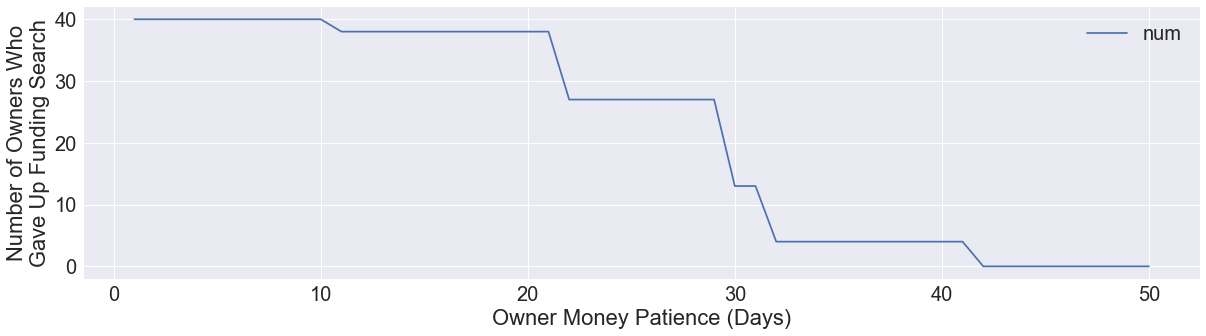

In [1352]:
results.plot(x = 'patience', y = 'num', figsize=(20,5))
plt.xlabel('Owner Money Patience (Days)')
plt.ylabel('Number of Owners Who\nGave Up Funding Search')
plt.show()

In [1353]:
results.head(10)

,patience,num,min,avg,max
1,1,40,11.5,24.175,31
2,2,40,12.5,25.175,32
3,3,40,13.5,26.175,33
4,4,40,14.5,27.175,34
5,5,40,15.5,28.175,35
6,6,40,16.5,29.175,36
7,7,40,17.5,30.175,37
8,8,40,18.5,31.175,38
9,9,40,19.5,32.175,39
10,10,40,20.5,33.175,40


In [1343]:
landlord_money_patience = 100000

owner_money_patience = 100
owner_money_patience_min = 1
owner_money_patience_max = 50
owner_money_patience_step = 1

# owner_home_patience = 40
owner_home_patience_min = 10000
owner_home_patience_max = 20000
owner_home_patience_step = 1000

renter_money_patience = 365
renter_home_patience = 550

In [1344]:
# df = households_to_df(owners)

results = pd.DataFrame(index = np.arange(start = owner_home_patience_min,
                                         stop = owner_home_patience_max+1,
                                         step = owner_home_patience_step),
                       columns = ('patience', 'num', 'min', 'avg', 'max'))

for owner_home_patience in np.arange(start = owner_home_patience_min,
                                     stop = owner_home_patience_max + 1,
                                     step = owner_home_patience_step):
    env = simpy.Environment()
    
    #############
    
    # Instantiate a FEMA Individual Assistance program
    fema_ia = HousingAssistanceFEMA(env, staff=100, budget=10000000, duration=fema_ia_dist, 
                                    max_outlay=30000, deadline=540, declaration=declaration)

    # Instantiate a SBA Loan program to use w/ OwnerHouseholds
    sba_home_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_home_sba_dist, 
                                    max_loan = 200000, min_credit = 600, deadline=sba_deadline,
                                    declaration=declaration)

    # Instantiate a SBA Loan program to use w/ Landlords (higher maximum for businesses)
    sba_biz_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_biz_sba_dist, 
                               max_loan = 2000000, deadline=sba_deadline, declaration=declaration) # SBA max biz loan = $2mil

    # Instantiate a private insurance program
    insurance = OwnersInsurance(env, staff=100, deductible=0.0, duration=insurance_dist)

    # Instantiate a rapid inspeaction (tagging) program
    inspection = InspectionProgram(env, staff=1000, duration=inspection_dist)

    # Instantiate a detailed engineering assessment program
    assessment = EngineeringAssessment(env, staff=1000, duration=assessment_dist)

    # Instantiate a building permit processing program
    permitting = PermitProgram(env, staff=1000, duration=permitting_dist) 

    # Instantiate a program to represent private repair contractors
    repair = RepairProgram(env, staff=1000, materials=1000000000, duration=repair_dist)

    # Instantiate a program to represent private demolition contractors
    demolition = DemolitionProgram(env, staff=1000, duration=demolition_dist)
    
    # Apply for insurance, FEMA IA, and SBA in that seqence
    insurance_ia_sba_seq = Insurance_IA_SBA_Sequential(env)

    # Apply for insurance, FEMA IA, and SBA in at the same time
    insurance_ia_sba_para = Insurance_IA_SBA_Parallel(env)

    # Apply for insurance first, then apply to FEMA IA and SBA at the same time
    insurance_firstthen_ia_sba_para = Insurance_FirstThen_IA_SBA_Parallel(env)

    # Apply for insurance and SBA in that seqence
    insurance_sba_seq = Insurance_SBA_Sequential(env)

    # Apply for insurance and SBA at the same time
    insurance_sba_para = Insurance_SBA_Parallel(env)

    # A policy to simulate government buyout to repair homes 
    repair_stock = RepairVacantBuilding(env)
    
    owned_stock = FilterStore(env)  # To put the residences associated with owners
    rented_stock = FilterStore(env) # To put the residences associated with renters

    forsale_stock = FilterStore(env) # To put the homes associated with vacant home sellers
    forrent_stock = FilterStore(env) # To put the homes associated with vacant home landlords
    
    owners = importEntities(env, owners_df, 'OwnerHousehold', owned_stock, write_story)
    
    renters = importEntities(env, renters_df, 'RenterHousehold', rented_stock, write_story)
    
    ################
    
    for i in range(len(owners)):
        env.process(owner_process(env, inspection, insurance, fema_ia, sba_home_loan, 
                                    assessment, permitting, demolition, repair,
                                    owned_stock, owners[i],
                             owner_money_patience, owner_home_patience))
        
    for i in range(len(renters)):
        env.process(renter_process(env, inspection, insurance, sba_biz_loan, assessment, permitting, 
                                    demolition, repair, rented_stock, renters[i],
                              renter_money_patience, renter_home_patience,
                              landlord_money_patience))
    
    env.run()
    print('ran successfully with owner_home_patience = %u' % owner_home_patience)
    
    df = households_to_df(owners)
    
    event_list=[]

    for i in df.columns:
        if "get" in i or "put" in i or "stop" in i or "start" in i or "name" in i or "gave" in i:
            event_list.append(i)

    event_df = df[event_list]
    event_df = event_df.set_index('name')
    
#     output_summary(owners, 'OwnerHousehold')
    
#     print(event_df['gave_up_funding_search'])
    results.loc[owner_home_patience, 'patience'] = owner_home_patience
    results.loc[owner_home_patience, 'num'] = len(event_df['gave_up_home_search'].loc[event_df['gave_up_home_search'] > 0])
    results.loc[owner_home_patience, 'min'] = np.min(event_df['gave_up_home_search'])
    results.loc[owner_home_patience, 'avg'] = np.mean(event_df['gave_up_home_search'])
    results.loc[owner_home_patience, 'max'] = np.max(event_df['gave_up_home_search'])
#     print('    # who gave up: %u' % len(event_df['gave_up_funding_search'].loc[event_df['gave_up_funding_search'] > 0]))
#     print('    minimum = %7.1f' % np.min(event_df['gave_up_funding_search']))
#     print('    average = %7.4f' % np.mean(event_df['gave_up_funding_search']))
#     print('    maximum = %7.1f' % np.max(event_df['gave_up_funding_search']))

ran successfully with owner_home_patience = 10000
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Frederick Leblanc had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Caroline Reid had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jennifer Conley had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Arnold had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Ryan Hernandez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mark Williams had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jeffrey Goodwin had an attribrute erro

Household Jeffrey Goodwin had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Elizabeth Rodriguez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Todd Turner had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Jordan Nichols had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Riley Lopez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kyle Anderson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Colin Young had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Mason Oconnell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Joseph Gross had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Allen Foster had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Househol

Household Lori Morgan had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Faith Clay had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Brandon Mcpherson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Andrew Sandoval had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Danielle Ferrell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Kevin Mcdowell had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tiffany Torres had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Emily Mcclure had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Nunez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Maria Berger had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Househo

Household Maria Berger had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Christopher Landry had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Hector Norton had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Megan Fletcher had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Tara Peters had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Chelsea Hudson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Katherine Jones had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Julie Neal had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Laura Mcclain had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Diane Stout had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household

Household Katherine Jones had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Julie Neal had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Laura Mcclain had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Diane Stout had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Teresa Smith had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household David Chavez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
ran successfully with owner_home_patience = 19000
Household Carol Reynolds had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Thomas Jackson had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Terri Bailey had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'
Household Frederick Leblanc had an attribrute error, 'OwnerHous

Household David Chavez had an attribrute error, 'OwnerHousehold' object has no attribute 'tenure'


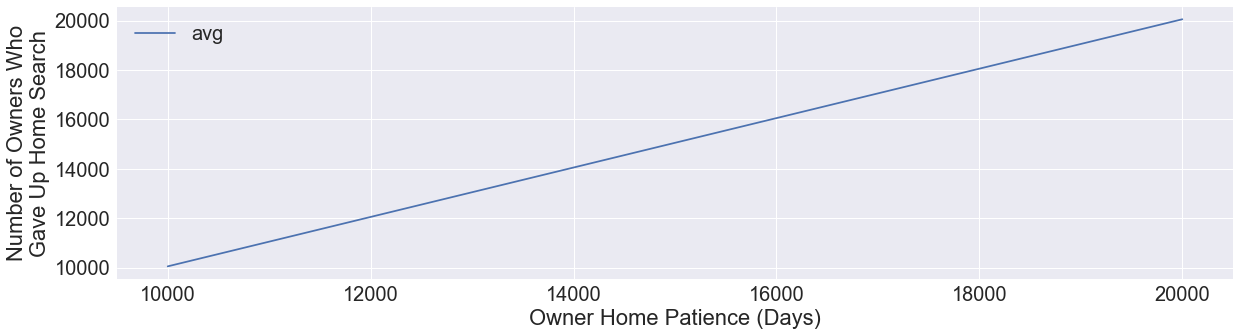

In [1345]:
results.plot(x = 'patience', y = 'avg', figsize=(20,5))
plt.xlabel('Owner Home Patience (Days)')
plt.ylabel('Number of Owners Who\nGave Up Home Search')
plt.show()

In [1346]:
results

,patience,num,min,avg,max
10000,10000,40,10040,10050.9,10071
11000,11000,40,11040,11050.9,11071
12000,12000,40,12040,12050.9,12071
13000,13000,40,13040,13050.9,13071
14000,14000,40,14040,14050.9,14071
15000,15000,40,15040,15050.9,15071
16000,16000,40,16040,16050.9,16071
17000,17000,40,17040,17050.8,17071
18000,18000,40,18040,18050.8,18071
19000,19000,40,19040,19050.8,19071


In [1126]:
#inspect.getfullargspec(owner_process).args # Useful to determine what arguments are required for the process.

for i in range(len(owners)):
    env.process(owner_process(env, inspection, insurance, fema_ia, sba_home_loan, 
                                    assessment, permitting, demolition, repair,
                                    owned_stock, owners[i],
                             owner_money_patience, owner_home_patience))

__Initiate the master process for each renter to be modeled in the simulation.__

In [1127]:
# # #inspect.getfullargspec(renter_process).args # Useful to determine what arguments are required for the process.

for i in range(len(renters)):
    env.process(renter_process(env, inspection, insurance, sba_biz_loan, assessment, permitting, 
                                    demolition, repair, rented_stock, renters[i],
                              renter_money_patience, renter_home_patience,
                              landlord_money_patience))

In [1128]:
# import pdb; pdb.set_trace()

## Run the simulation

In [1129]:
env.run()

UnboundLocalError: local variable 'money_search_start' referenced before assignment

# Summarize and visualize simulation outputs

## OwnerHousehold summary statistics

In [1191]:
output_summary(owners, 'OwnerHousehold')

40 out of 40 owners suffered damage to their homes.
 0 out of 40 owners rebuilt or repaired their damaged home.
 0 out of 40 owners gave up searching for money.
 40 out of 40 owners searchesd for a new home.
 0 out of 40 owners bought a new home.
 40 out of 40 owners gave up searching for a home.


In [ ]:
# owners[0].gave_up_home_search

## Print OwnerHousehold stories

In [ ]:
# owners[0].story

## RenterHousehold summary statistics

In [ ]:
output_summary(renters, 'RenterHousehold')

## Print RenterHousehold stories

In [ ]:
# renters[0].story

In [ ]:
df = households_to_df(owners)

In [ ]:
# df.columns

In [ ]:
csvfile = '/Users/AGeorgoff/Desktop/DESaster/scenarios/test/outputs/' + str(datetime.now().hour) + str(datetime.now().minute) + str(datetime.now().day) \
                 + str(datetime.now().month) + str(datetime.now().year) + '.csv'
    
df.to_csv(csvfile)

In [ ]:
# df.columns

In [ ]:
event_list=[]

for i in df.columns:
    if "get" in i or "put" in i or "stop" in i or "start" in i or "name" in i or "gave" in i:
        event_list.append(i)

event_df = df[event_list]
event_df = event_df.set_index('name')

In [ ]:
event_df['gave_up_home_search']

In [ ]:
event_df['gave_up_funding_search']

In [ ]:
# event_df

__Visualize events experienced by an individual entity.__

In [ ]:
names = sorted([f for f in df['name']])

name_chooser = Dropdown(
    options=names
)
display(name_chooser)

In [ ]:
name = name_chooser.value

name_row = df[df['name']==name][['inspection_put',
 'inspection_get',
 'fema_put',
 'fema_get',
 'assessment_put',
 'assessment_get',
 'permit_put',
 'permit_get',
'occupy_put',
'occupy_get',
 'home_put',
 'home_get']]

%matplotlib inline
plt.figure(figsize=(10,10))
sns.set_style(style="whitegrid")
sns.set(font_scale=2)
ax = sns.stripplot(name_row.iloc[0], name_row.columns, jitter=True, size = 15, linewidth=1)
ax.set(xlabel="Days After Event", ylabel="Housing Recovery Events for {0}".format(name))

Map of outputs

In [ ]:
mapfile = '/Users/geomando/Dropbox/@work/projects/DESaster/scenarios/test/outputs/' + 'folium_map_' + str(datetime.now().hour) + str(datetime.now().minute) + str(datetime.now().day) \
                 + str(datetime.now().month) + str(datetime.now().year) + '.html'
    
folium_map(df, outfile = mapfile)

Dashboard of outputs

In [ ]:
dashfile = '/Users/geomando/Dropbox/@work/projects/DESaster/scenarios/test/outputs/' + 'dashboard_' + str(datetime.now().hour) + str(datetime.now().minute) + str(datetime.now().day) \
                 + str(datetime.now().month) + str(datetime.now().year) + '.html'

dashboard(df, outfile = dashfile)